## New packages 
```pip install pydotplus```

```pip install graphviz```

Mac Command line
``` brew install graphviz```

For windows

Install windows package from: https://graphviz.gitlab.io/_pages/Download/Download_windows.html

Install python graphviz package

Add C:\Program Files (x86)\Graphviz2.38\bin to User path

Add C:\Program Files (x86)\Graphviz2.38\bin\dot.exe to System Path


In [ ]:
import pandas as pd
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
import numpy as np


In [ ]:
car = pd.read_csv("Data/car.data", header=None)

In [ ]:
car.columns=["buying", "maint", "doors", "persons", "lug_root", "safty", "class"]

In [ ]:
car.head(10)

In [ ]:
X=car[["buying", "maint", "doors", "persons", "lug_root", "safty"]]
y=car["class"]

In [ ]:
y.unique()

In [ ]:
ybin=y.copy()
ybin.loc[ybin!= "unacc"] = "acc" 

In [ ]:
ybin.unique()

In [ ]:
ysimp=pd.get_dummies(ybin)["acc"]

In [ ]:
ysimp.describe()

## One-hot encoding

In [ ]:
buying_1hot = pd.get_dummies(X['buying'], prefix = 'buying')

In [ ]:
maint_1hot = pd.get_dummies(X['maint'], prefix = 'maint')
doors_1hot = pd.get_dummies(X['doors'], prefix = 'doors')
persons_1hot = pd.get_dummies(X['persons'], prefix = 'persons')
lug_root_1hot = pd.get_dummies(X['lug_root'], prefix = 'lug_root')
safty_1hot = pd.get_dummies(X['safty'], prefix = 'safty')

In [ ]:
X1hot=pd.concat([safty_1hot, maint_1hot, buying_1hot, doors_1hot, persons_1hot, lug_root_1hot], axis=1)
X1hot.head(10)

## Build a Single Tree

In [ ]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
# Train Decision Tree Classifer
clf = clf.fit(X1hot, ybin)

In [ ]:
tree.plot_tree(clf)  

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = X1hot.columns, class_names=['acc', 'unacc'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [ ]:
graph.write_png('car.png')
Image(graph.create_png())

In [ ]:
np.sum(ybin[X1hot["safty_low"]==1]=="unacc")

## Checking the First Split

In [ ]:
import numpy as np

In [ ]:
def entropy(y):
    p1 = float(y.sum())/float(len(y))+1e-20
    return -(p1*np.log2(p1)+(1-p1)*np.log2(1-p1))

In [ ]:
np.sum(ysimp)

In [ ]:
entropy(ysimp)

In [ ]:
-(518.0/1728.0*np.log2(518.0/1728.0)+1210/1728.0*np.log2(1210/1728))

In [ ]:
def Dentropy(data, y, splitter):
    yleft=y[data[splitter]<0.5]
    yright=y[data[splitter]>=0.5]
    dH=entropy(y)-(len(yleft)*entropy(yleft)+len(yright)*entropy(yright))/float(len(yleft)+len(yright))
    return (dH, entropy(yleft), entropy(yright))

In [ ]:
feature_cols=list(X1hot.columns)
for i in feature_cols:
    print(i+": "+str(Dentropy(X1hot, ysimp, i)))

In [ ]:
clf.predict(X1hot[0:1])

In [ ]:
clf.predict_proba(X1hot[100:101])

In [ ]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=20)
# Train Decision Tree Classifer
clf = clf.fit(X1hot, ybin)

In [ ]:
clf.feature_importances_

## Multi-Class Classification

In [ ]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=2)
# Train Decision Tree Classifer
clf = clf.fit(X1hot, y)

In [ ]:
tree.plot_tree(clf)  

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = X1hot.columns, class_names=['acc', 'unacc'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [ ]:
np.unique(y, return_counts=True)

In [ ]:
p1=384.0/len(y)
p2=69.0/len(y)
p3=1210.0/len(y)
p4=65.0/len(y)

In [ ]:
p1*np.log2(p1)+p2*np.log2(p2)+p3*np.log2(p3)+p4*np.log2(p4)

## Random Forest to Predict House Price

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
houseprice = pd.read_csv('Data/housetrain.csv')

In [ ]:
houseprice.columns

In [ ]:
y = houseprice['SalePrice']
predictor_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']

# Create training predictors data
train_X = houseprice[predictor_cols]

## In Sample Model

In [31]:
rf = RandomForestRegressor(n_estimators = 1000, max_depth=None, random_state = 42)
# Train the model on training data
rf.fit(train_X, y);

In [ ]:
rf.feature_importances_

In [33]:
houseprice['ypred']=rf.predict(train_X)

In [ ]:
error=np.sqrt(np.dot((y-houseprice['ypred']), (y-houseprice['ypred'])))
print(error)

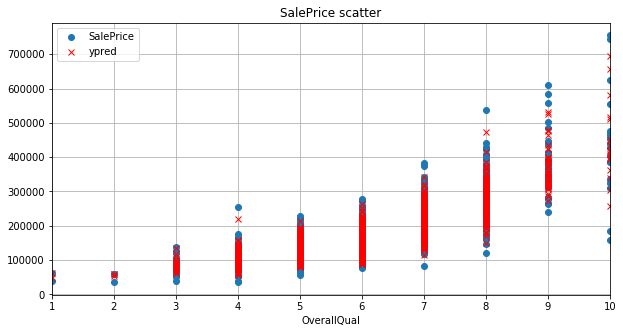

In [34]:
import matplotlib.pyplot as plt
houseprice.plot(x='OverallQual', y=['SalePrice', 'ypred'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('SalePrice scatter')
plt.show()

## Cross Validation 

In [42]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
kf = KFold(n_splits=10)
houseprice_shuffle=shuffle(houseprice)

y_shuffle = houseprice_shuffle['SalePrice']
predictor_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
# Create training predictors data
train_X_shuffle = houseprice_shuffle[predictor_cols]

In [47]:
errorls=[]
for ntrees in [10, 50, 100, 500, 1000]:
    y_pred_cv= np.empty((0, 1))
    rf = RandomForestRegressor(n_estimators = ntrees, max_depth=None,min_samples_leaf=1)
    for train, test in kf.split(train_X_shuffle):
        rf_modelcv=rf.fit(train_X_shuffle.iloc[train], y_shuffle.iloc[train]);
        y_pred_cv=np.append(y_pred_cv,rf_modelcv.predict(train_X_shuffle.iloc[test]))
    errorls.append(np.sqrt(np.dot(y_pred_cv-y_shuffle, y_pred_cv-y_shuffle)/len(y_shuffle)))

In [ ]:
houseprice_shuffle['y_pred_cv']=y_pred_cv
houseprice_shuffle['residual']=houseprice_shuffle['y_pred_cv']-houseprice_shuffle['SalePrice']

In [ ]:
houseprice_shuffle.plot(x='OverallQual', y=['residual'], figsize=(10,5), grid=True, style=['o','rx'])
plt.title('SalePrice scatter')
plt.show()

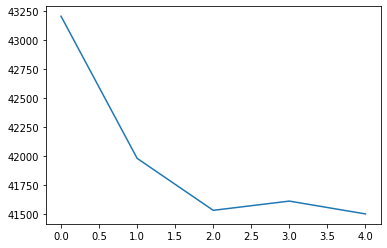

In [48]:
plt.plot(errorls)

In [ ]:
errorls